In [2]:
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
import torchvision
import collections
import pickle
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [191]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels =32, kernel_size= 4, stride = 2, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels =64, kernel_size= 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size= 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size= 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size= 4, stride = 2, padding = 1)

    def forward(self,x):
        num_images = x.shape[0]
        x = F.leaky_relu(self.bn1(self.conv1(x)),negative_slope=0.2)
        x =  F.leaky_relu(self.bn2(self.conv2(x)),negative_slope=0.2)
        x =  F.leaky_relu(self.bn3(self.conv3(x)),negative_slope=0.2)
        x =  F.leaky_relu(self.bn4(self.conv4(x)),negative_slope=0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.reshape(num_images,1)

class Generator(nn.Module):
  #100 dimensional uniform distribution Z is input from Figure 1 of the paper
  #First layer should have depth 1024. 1024/32 = 32
    def __init__(self):
        super().__init__()
        self.upscale1 = nn.ConvTranspose2d(in_channels=100, out_channels=1024,kernel_size=4,stride = 1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.upscale2 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,kernel_size=4,stride = 2,padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.upscale3 = nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=4,stride = 2,padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.upscale4 = nn.ConvTranspose2d(in_channels=256, out_channels=3,kernel_size=4,stride = 2,padding=1)
    def forward(self,x):
        x = F.relu(self.bn1(self.upscale1(x)))
        x = F.relu(self.bn2(self.upscale2(x)))
        x = F.relu(self.bn3(self.upscale3(x)))
        x = torch.tanh(self.upscale4(x))
        return x

In [192]:
#Test to make sure it works
num_chanels = 3 #num channels (RBG)
num_images =26
dim = 32 #dim of CIFAR10 dataset = 32x32 images
rand_image = torch.randn(num_images,num_chanels,dim,dim)
net = Discriminator()
out = net(rand_image)
#Checks to see if output are correct shape
print(list(out.shape))
if (list(out.shape) == [num_images,1]):
    print("The output is of correct shape")

[26, 1]
The output is of correct shape


In [193]:
#Test to make sure it works
num_chanels = 100 #num channels (RBG)
num_images =10
dim = 1 #dim of CIFAR10 dataset = 32x32 images
rand_image = torch.randn(num_images,num_chanels,dim,dim)
net = Generator()
out = net(rand_image)
#Checks to see if output are correct shape
print(list(out.shape))

[10, 3, 32, 32]


In [194]:
#initialize weights to be normally distributed N(0,0.02) as stated in the paper
discriminator = Discriminator().cuda()
for layer in discriminator.modules():
      if isinstance(layer,nn.Conv2d):
        nn.init.normal_(layer.weight.data,0,0.02)

generator = Generator().cuda()
for layer in discriminator.modules():
      if isinstance(layer,nn.ConvTranspose2d):
        nn.init.normal_(layer.weight.data,0,0.02)

In [195]:
#Functions used to save images from GANs
def sample_image_norm(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.randn(n_row, 100, 1, 1).cuda()
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.as_tensor(torch.LongTensor(labels))
    with torch.no_grad():
        gen_imgs = generator(z)
    save_image(gen_imgs.data, "DC_GAN_images_norm/%d.png" % batches_done, normalize=True)

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = torch.randn(n_row, 100, 1, 1).cuda()
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.as_tensor(torch.LongTensor(labels))
    with torch.no_grad():
        gen_imgs = generator(z)
    save_image(gen_imgs.data, "DC_GAN_images/%d.png" % batches_done, normalize=False)

In [196]:
#Make directory to store weights and images, etc
os.makedirs("DC_GAN_images", exist_ok=True)
os.makedirs("DC_GAN_images_norm", exist_ok=True)
os.makedirs("DC_GAN_data", exist_ok=True)
os.makedirs("DC_GAN_model", exist_ok=True)
os.makedirs("DC_GAN_GEN_WEIGHTS", exist_ok=True)
os.makedirs("DC_GAN_GEN_GRADS", exist_ok=True)
os.makedirs("DC_GAN_DISC_GRADS", exist_ok=True)

In [197]:
sample_interval=391
NUM_EPOCHS = 100
batch_size = 128
optimizer_gen = optim.Adam(generator.parameters(), lr = 0.0002)
optimizer_disc = optim.Adam(discriminator.parameters(), lr = 0.0002)

criterion = nn.BCELoss()
#used Adam, LR = 0.0002, 0.5 helped with training. Minibatch of 128 used,specified in the paper

#Simple Transforms as Specified in the Paper
transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [198]:
loss_g_list=[]
loss_d_list=[]
generator.train()
discriminator.train()

print("Ready to Run!")
for epoch in range(NUM_EPOCHS):
    grad_dict = collections.defaultdict(list)
    for batch_num, (real, _) in enumerate(dataloader):
        real = real.cuda()
        noise = torch.randn(batch_size, 100, 1, 1).cuda()
        fake = generator(noise)

        #Train the discriminator
        disc_real = discriminator(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        #Jansen-Shannon Distance
        loss_disc = 0.5 * (loss_disc_real + loss_disc_fake)
        discriminator.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        #Train the generator
        output = discriminator(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
        

    #Sample 64 images to be consistent with WGAN after epoch
    sample_image_norm(n_row=64, batches_done=epoch)
    sample_image(n_row=64, batches_done=epoch)

    torch.save({
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    #'optimizer_state_dict': optimizer_gen.state_dict(),
    'loss_gen': loss_gen,
    'loss_disc': loss_disc,
    }, "./DC_GAN_model/model"+str(epoch)+".pth")
    
    #Append loss
    loss_g_list.append(loss_gen)
    loss_d_list.append(loss_disc)
    #Record number of grads under 0.1, mean and std of gradients
    for layer in discriminator.modules():
        if isinstance(layer, nn.Conv2d):
            grad = layer.weight.grad.cpu().numpy()
            num_weights = (np.abs(grad) < 0.1).sum()
            mean = np.mean(grad)
            std = np.std(grad)
            val = [mean,std,num_weights]
            grad_dict[epoch].append(val)
    #Save gradient statistics as pickle file
    with open('grad_dict' + str(epoch) + '.pkl', 'wb') as f:
        pickle.dump(grad_dict, f)
    #Report Discriminator and Generator Loss
    print(
          "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
           % (epoch, NUM_EPOCHS, loss_disc.item(), loss_gen.item())
          )
    generator.train()
    discriminator.train()

Ready to Run!
[Epoch 0/100] [D loss: 0.002000] [G loss: 6.697128]
[Epoch 1/100] [D loss: 0.000904] [G loss: 7.477992]
[Epoch 2/100] [D loss: 0.006992] [G loss: 5.717838]
[Epoch 3/100] [D loss: 0.003778] [G loss: 5.714856]
[Epoch 4/100] [D loss: 0.064272] [G loss: 5.294133]
[Epoch 5/100] [D loss: 0.065079] [G loss: 6.501104]
[Epoch 6/100] [D loss: 0.030828] [G loss: 5.493885]
[Epoch 7/100] [D loss: 0.006949] [G loss: 8.197926]
[Epoch 8/100] [D loss: 0.069311] [G loss: 6.690518]
[Epoch 9/100] [D loss: 0.111193] [G loss: 4.253122]
[Epoch 10/100] [D loss: 0.322168] [G loss: 3.480689]
[Epoch 11/100] [D loss: 0.019010] [G loss: 5.589895]
[Epoch 12/100] [D loss: 0.085575] [G loss: 6.505891]
[Epoch 13/100] [D loss: 0.029942] [G loss: 3.343286]
[Epoch 14/100] [D loss: 0.034787] [G loss: 5.116631]
[Epoch 15/100] [D loss: 0.211250] [G loss: 8.259567]
[Epoch 16/100] [D loss: 0.125856] [G loss: 4.702266]
[Epoch 17/100] [D loss: 0.036050] [G loss: 5.714128]
[Epoch 18/100] [D loss: 0.017596] [G loss:

In [3]:
plt.figure()
vals = []
for epoch in range(100):
      with open('grad_dict' + str(epoch) + '.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
        for key in (loaded_dict):
            vals.append(loaded_dict[key][0][2])
            
plt.plot(list(range(0,200)),vals)
plt.xlabel("Epoch")
plt.ylabel("Number of Gradients Below 0.1")
plt.title("Number of Gradients Below 0.1 in DC-GAN in Second Layer")
plt.show()

NameError: name 'NUM_EPOCHS' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

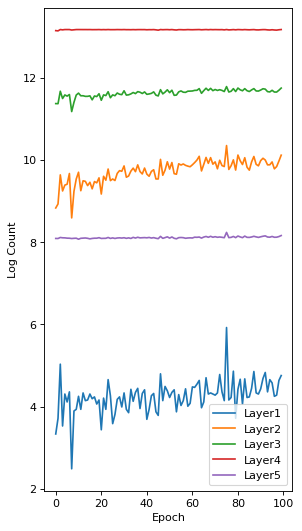

In [3]:
plt.figure()
vals = []
layer = []
epoch_vals = 100
num_layers = 5
plt.figure(figsize=(4, 8), dpi=80)
for layer in range(num_layers):
    if layer < 5:
        layer_val = []
        for epoch in range(epoch_vals):
              with open('grad_dict' + str(epoch) + '.pkl', 'rb') as f:
                loaded_dict = pickle.load(f)
                for key in (loaded_dict):
                    layer_val.append(loaded_dict[key][layer][2])
        plt.plot(list(range(epoch_vals)),np.log(layer_val),label = "Layer" + str(layer + 1))
        plt.xlabel("Epoch")
        plt.ylabel("Log Count")
        plt.legend()
        
#plt.plot(list(range(0,200)),vals)
#plt.title("Log Number of Gradients With Magnitude Less Than 0.1: DC-GAN")

plt.savefig('GradientCount.png')
plt.show()

In [22]:
import csv
data = []
with open('wganloss.csv', newline='') as csvfile:
    val = csv.reader(csvfile, delimiter=',', quotechar='|') 
    count = 0
    for row in val:
        data.append(list(row)) 
        print(row)

['', 'Epoch', 'Loss_D', 'Loss_G']
['0', '0/200', '-0.157786', '0.072773']
['1', '1/200', '-0.186499', '0.082615']
['2', '2/200', '-0.187309', '0.082631']
['3', '3/200', '-0.187137', '0.082456']
['4', '4/200', '-0.187919', '0.082997']
['5', '5/200', '-0.187628', '0.082841']
['6', '6/200', '-0.186855', '0.082281']
['7', '7/200', '-0.18808', '0.083066']
['8', '8/200', '-0.1883', '0.083047']
['9', '9/200', '-0.186761', '0.082228']
['10', '10/200', '-0.188151', '0.082943']
['11', '11/200', '-0.005086', '-0.093622']
['12', '12/200', '-0.187302', '0.082401']
['13', '13/200', '-0.185084', '0.081208']
['14', '14/200', '-0.061353', '0.042743']
['15', '15/200', '-0.187918', '0.082973']
['16', '16/200', '-0.187583', '0.082595']
['17', '17/200', '-0.188333', '0.083081']
['18', '18/200', '-0.185061', '0.08125']
['19', '19/200', '-0.171113', '0.075112']
['20', '20/200', '-0.185808', '0.08186']
['21', '21/200', '-0.187455', '0.082605']
['22', '22/200', '-0.136612', '-0.052072']
['23', '23/200', '-0.00

In [21]:
cd ..

/home/jovyan/work/ECE661Code


In [24]:
disc_loss_WGAN = []
count = 0
for epoch in data:
    if count == 0:
        count+=1 
        continue
    disc_loss_WGAN.append(float(epoch[2]))
    
disc_loss_WGAN = disc_loss_WGAN[1:]
print(len(disc_loss_WGAN))

99


<Figure size 432x288 with 0 Axes>

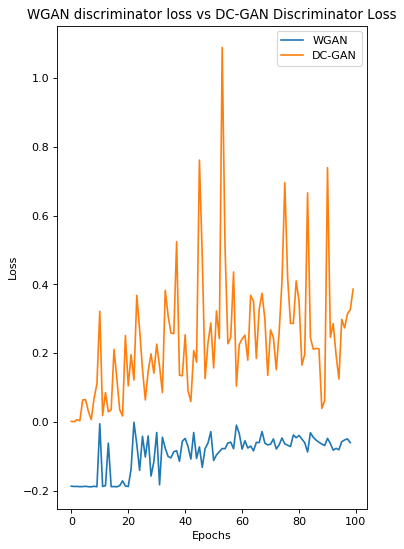

In [30]:
plt.figure()
plt.figure(figsize=(5, 8), dpi=80)
plt.plot(list(range(99)), disc_loss_WGAN,label = "WGAN")
plt.plot(list(range(100)),d,label = "DC-GAN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("WGAN discriminator loss vs DC-GAN Discriminator Loss")

plt.savefig("Image.png")
plt.show()

In [220]:
disc_loss_WGAN

['-0.157786',
 '-0.186499',
 '-0.187309',
 '-0.187137',
 '-0.187919',
 '-0.187628',
 '-0.186855',
 '-0.18808',
 '-0.1883',
 '-0.186761',
 '-0.188151',
 '-0.005086',
 '-0.187302',
 '-0.185084',
 '-0.061353',
 '-0.187918',
 '-0.187583',
 '-0.188333',
 '-0.185061',
 '-0.171113',
 '-0.185808',
 '-0.187455',
 '-0.136612',
 '-0.000804',
 '-0.064457',
 '-0.140423',
 '-0.041486',
 '-0.101592',
 '-0.040351',
 '-0.157159',
 '-0.115391',
 '-0.030431',
 '-0.182486',
 '-0.044078',
 '-0.076272',
 '-0.10015',
 '-0.104103',
 '-0.086103',
 '-0.083371',
 '-0.114154',
 '-0.055786',
 '-0.047576',
 '-0.071182',
 '-0.107674',
 '-0.030399',
 '-0.105789',
 '-0.072299',
 '-0.13168',
 '-0.076776',
 '-0.061371',
 '-0.027907',
 '-0.111738',
 '-0.095605',
 '-0.085966',
 '-0.07705',
 '-0.0775',
 '-0.060835',
 '-0.058605',
 '-0.077625',
 '-0.009022',
 '-0.033449',
 '-0.078793',
 '-0.05449',
 '-0.075479',
 '-0.06983',
 '-0.083769',
 '-0.059182',
 '-0.059825',
 '-0.027574',
 '-0.061382',
 '-0.06658',
 '-0.064506',
 '-

In [4]:
 pwd

'/home/jovyan/work/ECE661Code'

In [5]:
cd DC_GAN_model/

/home/jovyan/work/ECE661Code/DC_GAN_model


In [10]:
d = []
g = []
for epoch in range(100):
    x = torch.load("model"+str(epoch)+".pth")
    d.append(x["loss_disc"].item())
    g.append(x["loss_gen"].item())

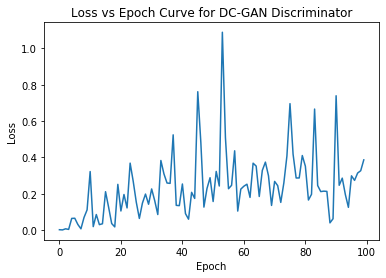

In [16]:
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch Curve for DC-GAN Discriminator")
plt.savefig('disc.png')


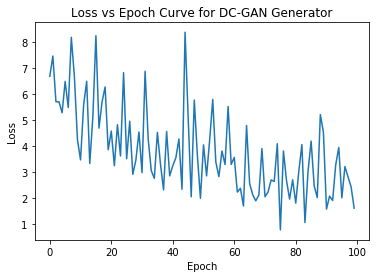

In [15]:
plt.plot(g)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch Curve for DC-GAN Generator")
plt.savefig('gen.png')
